# EDA
In this study, the EDA will be focused on the training data, which will be betwee 1 April 2023 to 31 March 2024

In [2]:
# Import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

hourly_data = pd.read_csv('../..//data/hourly_data.csv')
three_hourly_data = pd.read_csv('../../data/three_hourly_data.csv')
daily_data = pd.read_csv('../../data/daily_data.csv')


# Train-test split
# Sort the data by date
hourly_data['Date'] = pd.to_datetime(hourly_data['Date'])
three_hourly_data['Date'] = pd.to_datetime(three_hourly_data['Date'])
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

hourly_data = hourly_data.sort_values('Date')

# Determine when the first year ends, and use it as train data
# The rest of the data is used as test data
min_date = hourly_data['Date'].min()
max_date = hourly_data['Date'].max()

# Calculate the total time span of the data
total_time_span = max_date - min_date

# Define the first year of data
first_year_end = min_date + pd.DateOffset(years=1)

# Filter data for the first year
first_year_data = hourly_data[hourly_data['Date'] <= first_year_end]

# Calculate the percentage of data in the first year
percentage_first_year = (len(first_year_data) / len(hourly_data))

train_split = percentage_first_year

# Hourly data train-test split
X_train_hourly = hourly_data[hourly_data['Date'] <= first_year_end]
X_test_hourly = hourly_data[hourly_data['Date'] > first_year_end]

# Three hourly data train-test split
X_train_three_hourly = three_hourly_data[three_hourly_data['Date'] <= first_year_end]
X_test_three_hourly = three_hourly_data[three_hourly_data['Date'] > first_year_end]

# Daily data train-test split
X_train_daily = daily_data[daily_data['Date'] <= first_year_end]
X_test_daily = daily_data[daily_data['Date'] > first_year_end]

## Daily Returns vs RV

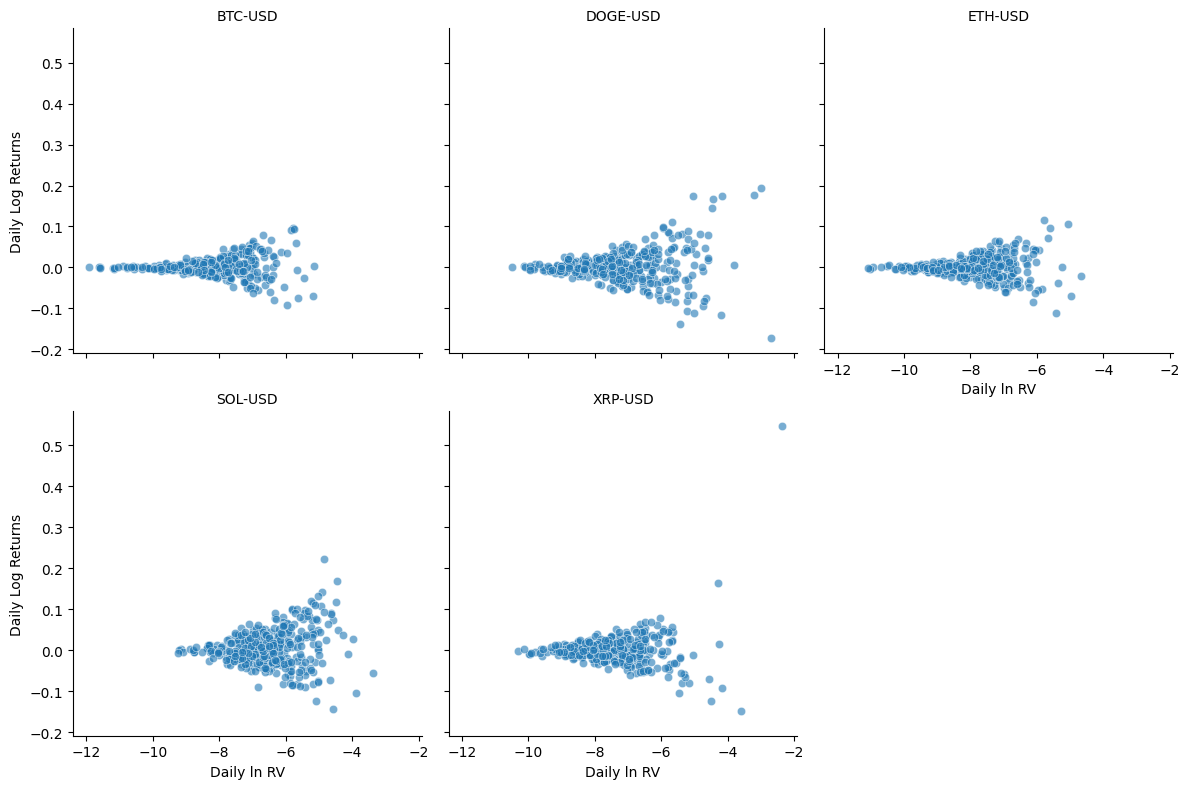

Ticker
BTC-USD     0.002454
DOGE-USD    0.002523
ETH-USD     0.001793
SOL-USD     0.006060
XRP-USD     0.000496
Name: ln_daily_return, dtype: float64
Ticker
BTC-USD    -8.212067
DOGE-USD   -7.292734
ETH-USD    -7.948952
SOL-USD    -6.520270
XRP-USD    -7.456567
Name: ln_daily_rv, dtype: float64


In [3]:
g = sns.FacetGrid(data=X_train_daily, col='Ticker', col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.scatterplot, 'ln_daily_rv', 'ln_daily_return', alpha=0.6)
g.set_titles("{col_name}")
g.set_axis_labels("Daily ln RV", "Daily Log Returns")
plt.tight_layout()
plt.show()

# Calculate the mean of the daily log returns
mean_daily_return = X_train_daily.groupby('Ticker')['ln_daily_return'].mean()
mean_daily_rv= X_train_daily.groupby('Ticker')['ln_daily_rv'].mean()
print(mean_daily_return)
print(mean_daily_rv)

### RV Trends

/var/folders/cx/mjdsxp6x367bkv2wc28scrt80000gn/T/ipykernel_13477/4112405514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_daily['Date'] = pd.to_datetime(X_train_daily['Date'])
/var/folders/cx/mjdsxp6x367bkv2wc28scrt80000gn/T/ipykernel_13477/4112405514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_daily['Days_Since_Start'] = (X_train_daily['Date'] - X_train_daily['Date'].min()).dt.days
/var/folders/cx/mjdsxp6x367bkv2wc28scrt80000gn/T/ipykernel_13477/4112405514.py:27: FutureWarning

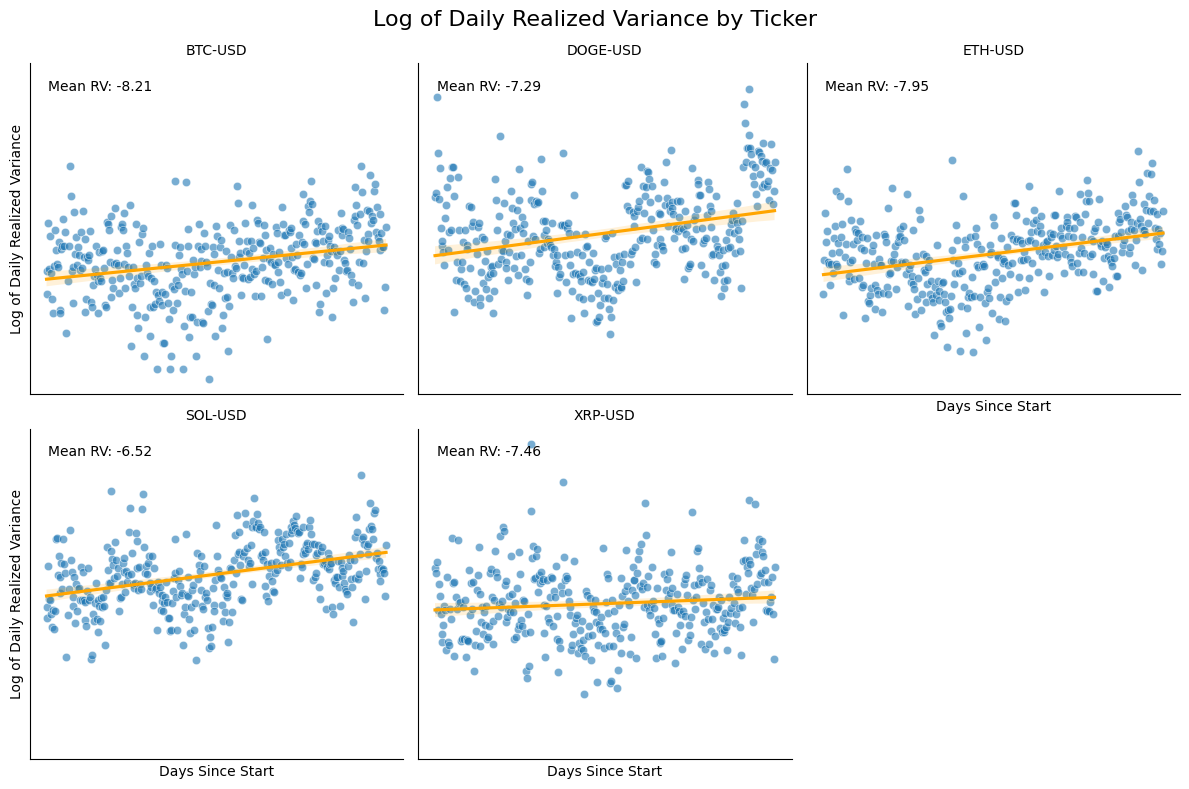

In [4]:
# Ensure Date is datetime
X_train_daily['Date'] = pd.to_datetime(X_train_daily['Date'])

# Convert Date to numerical format for regression (days since the first date)
X_train_daily['Days_Since_Start'] = (X_train_daily['Date'] - X_train_daily['Date'].min()).dt.days

# Plot the hourly log returns for all tickers
g = sns.FacetGrid(data=X_train_daily, col='Ticker', col_wrap=3, height=4, sharex=True, sharey=True)

# Map scatterplot to each facet
g.map(sns.scatterplot, 'Days_Since_Start', 'ln_daily_rv', alpha=0.6)

# Add a regression line to each facet
g.map(sns.regplot, 'Days_Since_Start', 'ln_daily_rv', scatter=False, color='orange')

# Set titles and axis labels
g.set_titles("{col_name}", fontsize=12)  # Adjust title font size
g.set_axis_labels("Days Since Start", "Log of Daily Realized Variance")  # Correct axis labels

# Add gridlines for better readability
g.set(xticks=[], yticks=[])  # Remove default ticks if not needed
g.fig.subplots_adjust(top=0.9)  # Adjust spacing for titles
g.fig.suptitle('Log of Daily Realized Variance by Ticker', fontsize=16)  # Add an overall title

# Add their coefficients to the plot
for i, ax in enumerate(g.axes.flat):
    ax.text(0.05, 0.95, f"Mean RV: {mean_daily_rv[i]:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

# Correlation plots of returns

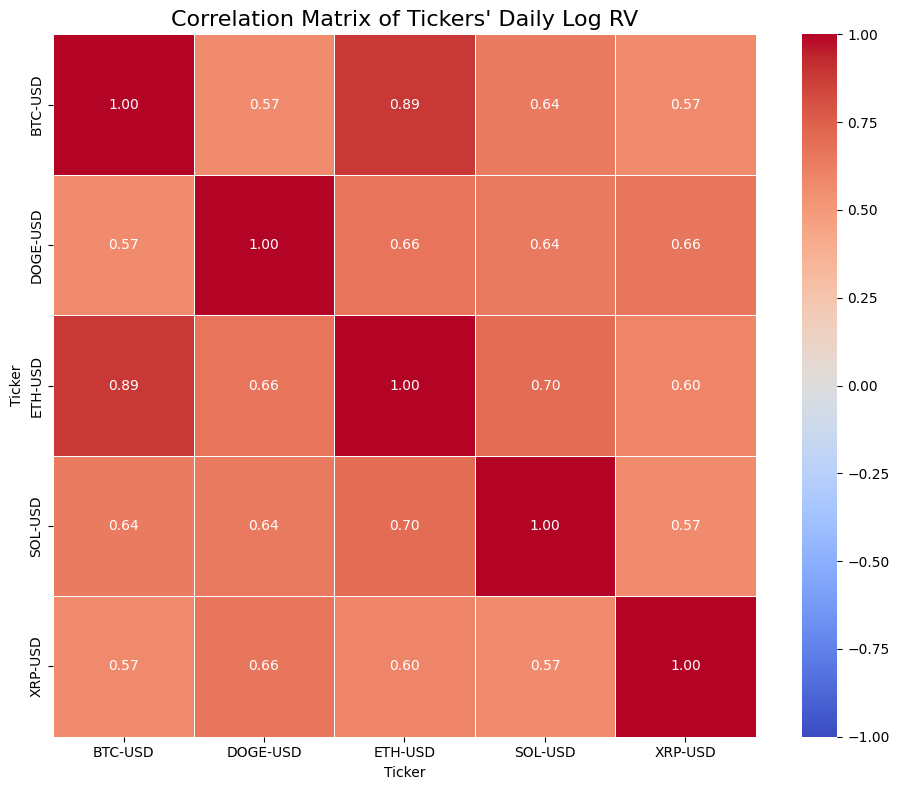

In [5]:

# Drop rows with NaN in ln_daily_rv (first row for each ticker)
data_resampled = X_train_daily.dropna(subset=['ln_daily_rv'])

# Pivot the data to have one column per ticker's daily log returns
daily_returns_pivot = data_resampled.pivot(index='Date', columns='Ticker', values='ln_daily_rv')

# Fill missing values and clean up
daily_returns_pivot = daily_returns_pivot.ffill().bfill().dropna()

# Calculate the correlation matrix
correlation_matrix = daily_returns_pivot.corr()


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Annotate the heatmap with correlation values
    fmt=".2f",  # Format the annotations to 2 decimal places
    cmap="coolwarm",  
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,  # Ensure the plot is square
)
plt.title('Correlation Matrix of Tickers\' Daily Log RV', fontsize=16)
plt.tight_layout()
plt.show()

### Summary statistics

#### Ln Hourly Returns

In [6]:
summary_stats = X_train_hourly.groupby(['Ticker', 'Risk'])['ln_hourly_return'].agg(
    Mean='mean',
    SD='std',
    Min='min',
    Max='max'
).reset_index().rename(columns={'Ticker': 'Coin'})

# Define the desired order for the Risk groups
risk_order = ['Baseline', 'Low Risk', 'Medium Risk', 'High Risk']

# Convert the 'Risk' column to a categorical type with the specified order
summary_stats['Risk'] = pd.Categorical(summary_stats['Risk'], categories=risk_order, ordered=True)

# Sort the summary statistics by Risk in the desired order
summary_stats = summary_stats.sort_values(by=['Risk'])

print(summary_stats)


       Coin         Risk      Mean        SD       Min       Max
0   BTC-USD     Low Risk  0.000105  0.004620 -0.061683  0.053272
2   ETH-USD     Low Risk  0.000079  0.005164 -0.073743  0.048796
4   XRP-USD  Medium Risk  0.000019  0.007586 -0.157708  0.218381
1  DOGE-USD    High Risk  0.000120  0.009130 -0.174408  0.174589
3   SOL-USD    High Risk  0.000259  0.010164 -0.152863  0.116354


#### Ln Hourly RV

In [7]:
summary_stats = X_train_hourly.groupby(['Ticker', 'Risk'])['ln_hourly_rv'].agg(
    Mean='mean',
    SD='std',
    Min='min',
    Max='max'
).reset_index().rename(columns={'Ticker': 'Coin'})

# Define the desired order for the Risk groups
risk_order = ['Baseline', 'Low Risk', 'Medium Risk', 'High Risk']

# Convert the 'Risk' column to a categorical type with the specified order
summary_stats['Risk'] = pd.Categorical(summary_stats['Risk'], categories=risk_order, ordered=True)

# Sort the summary statistics by Risk in the desired order
summary_stats = summary_stats.sort_values(by=['Risk'])

print(summary_stats)

# Save as csv
summary_stats.to_csv('../../results/ln_hourly_rv_summary_stats.csv', index=False)

       Coin         Risk       Mean        SD        Min       Max
0   BTC-USD     Low Risk -12.999954  2.533356 -27.701600 -5.571500
2   ETH-USD     Low Risk -12.789053  2.588702 -32.098383 -5.214328
4   XRP-USD  Medium Risk -12.265120  2.550954 -26.430015 -3.043025
1  DOGE-USD    High Risk -12.126309  2.724969 -31.871272 -3.490636
3   SOL-USD    High Risk -11.200828  2.518743 -26.510945 -3.756426


### XRP
XRP exhibited unique properties WRT time series data

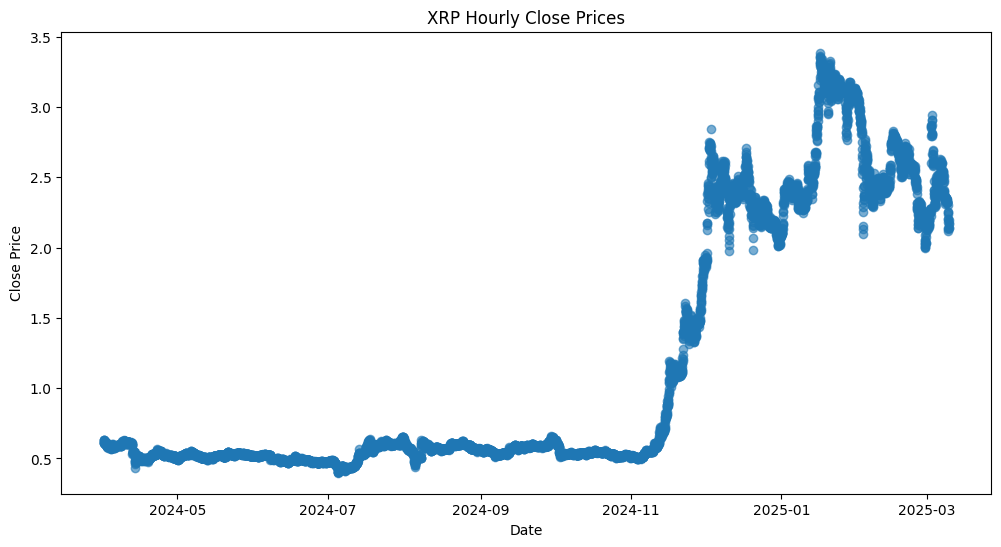

In [15]:
# Filter for XRP in X_test_hourly
XRP_hourly = X_test_hourly[X_test_hourly['Ticker'] == 'XRP-USD']

# Plot the hourly log returns for XRP
plt.figure(figsize=(12, 6))
plt.scatter(XRP_hourly['Date'], XRP_hourly['Close'], alpha=0.6)
plt.title('XRP Hourly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()
